# Vanilla BCPNN and digit recall
In this example I showcase how the BCPNN works as it most basic and provide a more complicated example with digit recall. 

The first thing that we do is to import all the libraries that we will need.

In [1]:
from __future__ import print_function
import subprocess
import sys 
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import datasets
from matplotlib import ticker

from network import BCPNN
from connectivity_functions import get_beta, get_w, softmax
from data_transformer import transform_normal_to_neural_single
from data_transformer import transform_neural_to_normal_single
from connectivity_functions import calculate_probability, calculate_coactivations


%matplotlib inline

We always get the git version that we are running in case we want to do checkout


In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'ae918e0766c21af41fee514e438a5c81c7c8b5a3'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Hash before the change', hash_at_the_moment)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

Hast before teh change 6f6eb56db4d331485cd290f41727eb468b8d7450


0

## Vanilla BCPNN

In [3]:
# First we set the patterns
pattern1 = transform_normal_to_neural_single(np.array((1, 0, 0, 0, 0)))
pattern2 = transform_normal_to_neural_single(np.array((0, 0, 0, 0, 1)))
patterns = [pattern1, pattern2]

In [4]:
# Then we calculate the probabilities and joint-probabilities
P = calculate_coactivations(patterns)
p = calculate_probability(patterns)

w = get_w(P, p)
beta = get_beta(p)

In [5]:
# We define the Neural Network and the time course
nn = BCPNN(beta, w)

dt = 0.1
T = 1.0
time = np.arange(0, T + dt, dt)

history_o = np.zeros((time.size, beta.size))
history_s = np.zeros_like(history_o)

In [6]:
# We run the code now
for index_t, t in enumerate(time):
    nn.update_continuous(dt)
    history_o[index_t, :] = nn.o
    history_s[index_t, :] = nn.s

#### Plotting
Here we illustrate how the process evolved with each time step dt

<matplotlib.colorbar.Colorbar instance at 0x7f5a3be071b8>

/home/heberto/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


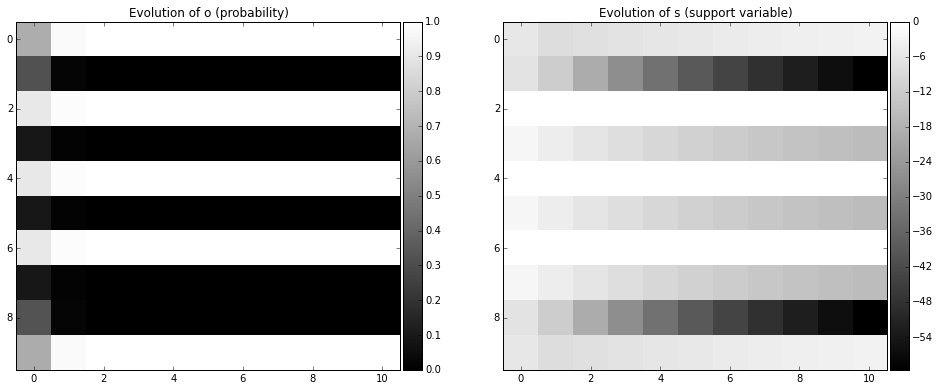

In [7]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(history_o.T, cmap='gray', interpolation='nearest')
ax1.set_title('Evolution of o (probability)')

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(history_s.T, cmap='gray', interpolation='nearest')
ax2.set_title('Evolution of s (support variable)')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2)

In [8]:
np.set_printoptions(suppress=True)
x = transform_neural_to_normal_single(nn.o)
print('Final pattern', x)

Final pattern [ 0.          0.00000014  0.00000014  0.00000014  1.        ]


We see that the evolution of the probability is quite fast and abrupt (I believe this is because of the normalization of the process) whereas the evolution of the support variable is more continous and nuanced.

## Digit recall
In this example I evolve a BCPNN discretly in its most simple ways just to prove that it is useful to encode more complicated patterns

In [9]:
# Load and transform the data
digits = datasets.load_digits()

images = digits['images']
data = digits['data']
target_names = digits['target_names']
target = digits['target']

# Let's binarize the image
data[data < 8] = 0
data[data >= 8] = 1

In [10]:
# Let's get two images and learn them as a pattern
number_of_patterns = 2
patterns = []
for i in range(number_of_patterns):
    patterns.append(data[i])

In [11]:
# Load neural patterns, probabilities and get connectivity and bias
neural_patterns = [transform_normal_to_neural_single(pattern) for pattern in patterns]

p = calculate_probability(neural_patterns)
P = calculate_coactivations(neural_patterns)

w = get_w(P, p)
beta = get_beta(p)

In [12]:
# Instantiate the neural network and define the time course
# Here we have the evolution
T = 10
dt = 0.1
tau_m = 1.0
G = 1.0

network = BCPNN(beta, w, G=G, tau_m=tau_m)
initial_image = np.copy(transform_neural_to_normal_single(network.o).reshape(8, 8))

In [13]:
# Here we evolve the network and get the final image
network.update_discrete(T)

final_image = transform_neural_to_normal_single(network.o).reshape(8, 8)

#### Now we plot the final result

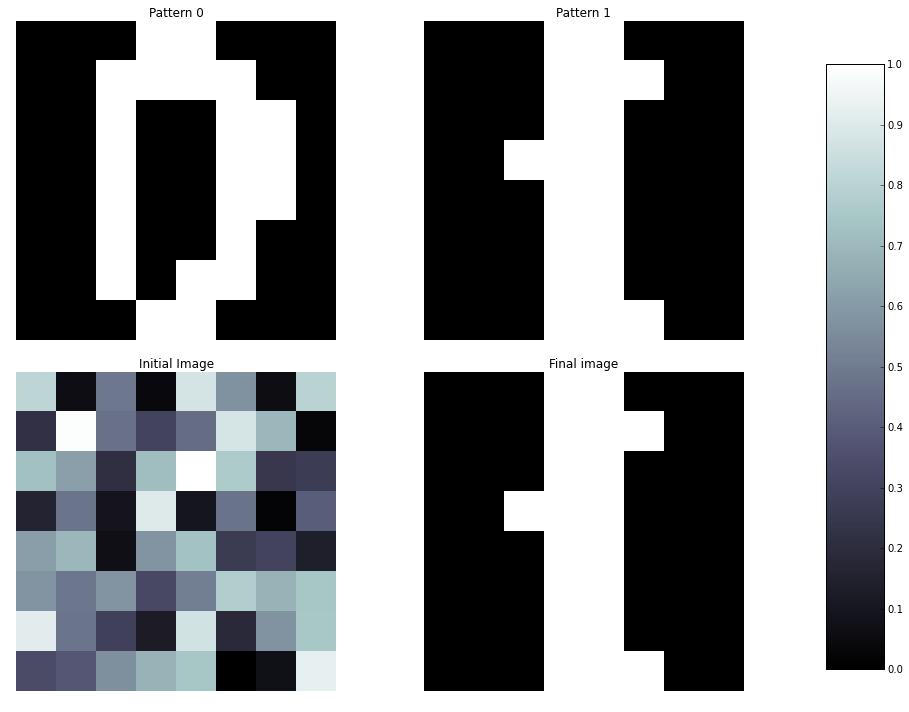

In [14]:
gs = gridspec.GridSpec(number_of_patterns, number_of_patterns, wspace=0.1, hspace=0.1)
cmap = cm.bone
interpolation = 'nearest'

fig = plt.figure(figsize=(16, 12))

for i in range(number_of_patterns):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(patterns[i].reshape(8, 8), cmap=cmap, interpolation=interpolation)
    ax.set_title('Pattern ' + str(i))
    ax.set_axis_off()


ax10 = fig.add_subplot(gs[1:, 0:(number_of_patterns/2)])
im10 = ax10.imshow(initial_image, cmap=cmap, interpolation=interpolation)
ax10.set_title('Initial Image')
ax10.set_axis_off()


ax11 = fig.add_subplot(gs[1:, (number_of_patterns/2):])
im11 = ax11.imshow(final_image, cmap=cmap, interpolation=interpolation)
ax11.set_title('Final image')
ax11.set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im11, cax=cbar_ax)

We see that the image starts with mostly noise but converges to one of the patterns that we stored.

#### Returning git to original

At the end we return to the original commit with git

In [15]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])

0